In [20]:
import tensorflow_datasets as tfds
import tensorflow as tf
import logging, os
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

BASE_PATH = "../../../../../local_data/practice/tfds/"
DATA_PATH = "../../../../../local_data/tfds/"
OUTPUT_PATH = BASE_PATH+"mnist_transfer/"
os.system("mkdir -p " + OUTPUT_PATH)

train_dataset, validation_dataset = tfds.load(
    "mnist",
    data_dir=DATA_PATH,
    split=["train[:40%]", "train[40%:50%]"],
    as_supervised=True,  # Include labels
)

num_train = tf.data.experimental.cardinality(train_dataset)
num_test = tf.data.experimental.cardinality(validation_dataset)

print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_test}")

Number of training samples: 24000
Number of validation samples: 6000


2025-07-19 21:19:07.995098: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


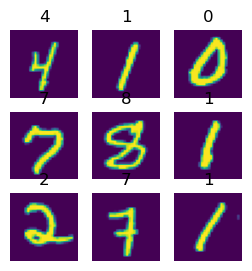

In [21]:
plt.figure(figsize=(3, 3))
for i, (image, label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [22]:
def reshape_image(image, label):
    image = tf.reshape(image, (28, 28, 1))
    return image, label

train_dataset = train_dataset.map(reshape_image)   
def convert_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

train_dataset = train_dataset.map(convert_to_rgb)   
validation_dataset = validation_dataset.map(convert_to_rgb)   


2025-07-19 21:19:08.365371: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


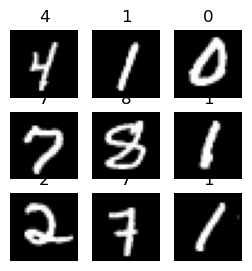

In [23]:
plt.figure(figsize=(3, 3))
for i, (image, label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [24]:
size = (150, 150)

train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
validation_dataset = validation_dataset.map(lambda x, y: (tf.image.resize(x, size), y))

batch_size = 32

train_dataset = train_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
validation_dataset = validation_dataset.cache() \
    .batch(batch_size).prefetch(buffer_size=10)

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

In [25]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


In [26]:

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. 
# We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, 
# so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(10)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                           

In [27]:
model.compile(
    # optimizer=tf.keras.optimizers.Adam(0.001),
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [ ]:
epochs = 10
# model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)
history =model.fit(train_dataset, epochs=epochs,validation_data=validation_dataset)

Epoch 1/10
750/750 [==============================] - 18s 22ms/step - loss: 0.6868 - sparse_categorical_accuracy: 0.7795 - val_loss: 0.4101 - val_sparse_categorical_accuracy: 0.8770
Epoch 2/10
750/750 [==============================] - ETA: 0s - loss: 0.4425 - sparse_categorical_accuracy: 0.8551